<a href="https://colab.research.google.com/github/dewaalaw/dsprojects/blob/main/traffic-flow-forecast/src/traffic_flow_forecasting_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook the traffic flow forecasting continues from the traffic_flow_forecasting notebook, part_1, using a Recurrent Neural Network (RNN), notably the Long Short-Term Memory archictecture (LSTM). An LSTM uses past information with new information to predict output. It resolves a conventional RNN's short-term memory loss caused by a vanishing gradient. Small gradients bring about insignificant to no changes in the weight, resulting in weights un-updated that terminates network learning. (As as aside, weights are assigned to each feature to mark their contribution in predicting the target.)

# Development Environment

In [33]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [34]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Load data

In [35]:
train_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_train.csv', index_col=0)
val_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_validate.csv', index_col=0)
test_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [36]:
# set filepath to images folder
images_dir = '/gdrive/My Drive/TrafficFlowImages'

In [49]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [37]:
class DataWindow():
  # Initialise a DataWindow object
  def __init__(self, input_width, label_width, shift, train_df=train_df, 
             val_df=val_df, test_df=test_df, label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    
    # Name of column to predict
    self.label_columns = label_columns
    if label_columns is not None:
      # Dict. of name and index of label column. Used for plotting.
      self.label_columns_indices = {name: i for i, name in 
                                    enumerate(label_columns)}
    # Dict. of name and index of each column. Used for plotting.
    # Used to seperate the features from target variable
    self.column_indices = {name: i for i, name in 
                                    enumerate(train_df.columns)}
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    # Returns a slice object that specifies how to slice a sequence.
    # In this case, it says that hte input slice starts at 0, ends when 
    # input_width is reached
    self.input_slice = slice(0, input_width)
      
    # Assign indices to the inputs. These are usefull for plotting.
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
      
    # Get the index at which the label starts. In this case, it's the total 
    # window size less the width of the label.
    self.label_start = self.total_window_size - self.label_width
    # Repeat steps applied for input for labels
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
  # Seperate the big data window into two windows: one for inputs, 
  # the other for the lables
  def split_to_inputs_labels(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], 
          axis=-1
      )
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  # Plot sample of data windows
  def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
    inputs, labels = self.sample_batch

    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [scaled]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
               label='Inputs', marker='.', zorder=-10)
      
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue  
      
      plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                  edgecolors='k', marker='s', label='Labels', c='green', s=64)
      
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='red', 
                    s=64)
      
      if n == 0:
        plt.legend()
    
    plt.xlabel('Time (h)')
  
  # Format dataset into tensors, fed to dl model.
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # Use tensor timeseries_dataset_from_array function to create a dataset of 
    # sliding windows.
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data,
        # targets are handled by the split_to_input_labels function, 
        # thus set to none.
        targets = None,
        sequence_length = self.total_window_size,
        # Number of timesteps seperating each sequence.
        # In this case sequences are consecutive hence sequence_stride equall 1
        sequence_stride = 1,
        # Shuffle the batch sequence, not the window/sequence timesteps
        shuffle = True,
        # Sequences in a batch
        batch_size=32
    )

    ds = ds.map(self.split_to_inputs_labels)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)
    
  @property
  def val(self):
    return self.make_dataset(self.val_df)
    
  @property
  def test(self):
    return self.make_dataset(self.test_df)
    
  @property
  def sample_batch(self):
    result = getattr(self, '_sample_batch', None)
    if result is None:
      result = next(iter(self.train))
      self._sample_batch = result
    return result

In [38]:
# DEF: Configure deep learning model and fit data.
# patience: number of epochs after which model stops training-
# granted the validation loss does not improve.
# max_epochs: maximum number of epochs to train the model. Method stops when 3- 
# consecutive epochs do not decrease the validation loss.
def compile_and_fit(model, window, patience=3, max_epochs=50):
  early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=patience, 
                                 mode='min')
  
  model.compile(loss=MeanSquaredError(), # Use MSE as loss function.
                # Adam's an optimiser proivding a method that descends the 
                # gradient applied to the weights of the layers.
                # Use MAE as error metric
                optimizer=Adam(),
                metrics=[MeanAbsoluteError()]) 
  
  history = model.fit(window.train, # Fit model on training set
                      epochs=max_epochs, 
                      validation_data=window.val, # Use validation set to calc validation loss
                      callbacks=[early_stopping]) # Pass early_stopping as a calllback
  
  return history
     

# Long Short-Term Memory (LSTM) Model

## Single Step Model

In [39]:
wide_window= DataWindow(input_width=24, label_width=24, shift=1, 
                        label_columns=['traffic_volume'])

In [40]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True), Dense(units=1)
    ])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 12s 21ms/step - loss: 0.0330 - mean_absolute_error: 0.1271 - val_loss: 0.0104 - val_mean_absolute_error: 0.0732
Epoch 2/50
384/384 [==============================] - 9s 23ms/step - loss: 0.0069 - mean_absolute_error: 0.0594 - val_loss: 0.0048 - val_mean_absolute_error: 0.0497
Epoch 3/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0045 - mean_absolute_error: 0.0477 - val_loss: 0.0035 - val_mean_absolute_error: 0.0423
Epoch 4/50
384/384 [==============================] - 6s 17ms/step - loss: 0.0037 - mean_absolute_error: 0.0423 - val_loss: 0.0030 - val_mean_absolute_error: 0.0383
Epoch 5/50
384/384 [==============================] - 9s 22ms/step - loss: 0.0033 - mean_absolute_error: 0.0395 - val_loss: 0.0028 - val_mean_absolute_error: 0.0371
Epoch 6/50
384/384 [==============================] - 6s 17ms/step - loss: 0.0030 - mean_absolute_error: 0.0376 - val_loss: 0.0026 - val_mean_absolute_error: 0.0356
Epoch 7/5

### Plot

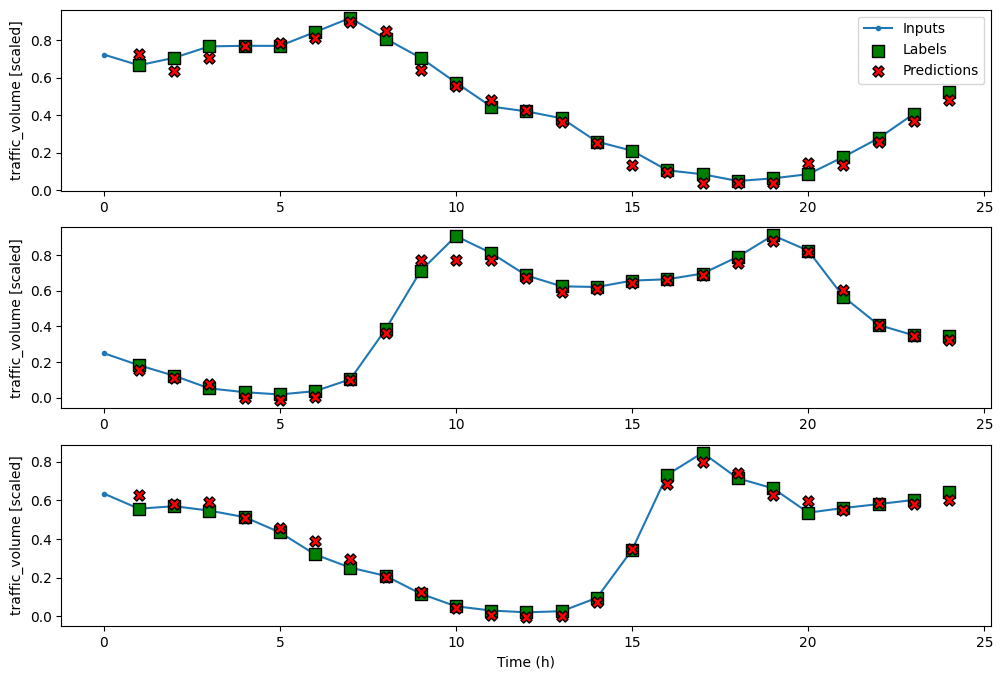

In [50]:
wide_window.plot(lstm_model)

### Compare Single-Step Models

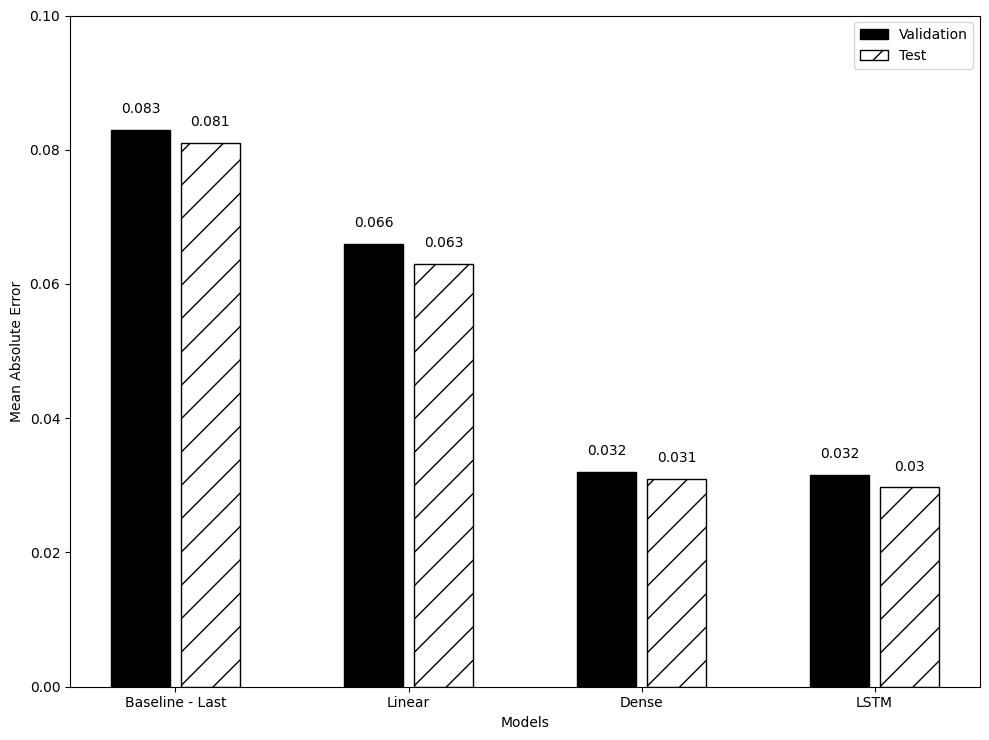

In [51]:
# MAE's of Single-Step Models from traffic_flow_forecasting_part_1.ipynb
mae_val = [0.083, 0.066, 0.032]
mae_test = [0.081, 0.063, 0.031]

# Add LSTM model results to the above arrays 
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

# ---------------------------------------------------------------
x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')
  
for index, value in enumerate(mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig(f'{images_dir}/compare_single_step_models', dpi=300)

## Multi-Step Model

In [43]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, 
                          label_columns=['traffic_volume'])

In [44]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True), 
    Dense(1, kernel_initializer=tf.initializers.zeros)
    ])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 11s 20ms/step - loss: 0.0486 - mean_absolute_error: 0.1596 - val_loss: 0.0222 - val_mean_absolute_error: 0.1055
Epoch 2/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0173 - mean_absolute_error: 0.0921 - val_loss: 0.0175 - val_mean_absolute_error: 0.0897
Epoch 3/50
383/383 [==============================] - 7s 18ms/step - loss: 0.0150 - mean_absolute_error: 0.0835 - val_loss: 0.0163 - val_mean_absolute_error: 0.0846
Epoch 4/50
383/383 [==============================] - 7s 19ms/step - loss: 0.0142 - mean_absolute_error: 0.0800 - val_loss: 0.0158 - val_mean_absolute_error: 0.0826
Epoch 5/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0139 - mean_absolute_error: 0.0784 - val_loss: 0.0156 - val_mean_absolute_error: 0.0814
Epoch 6/50
383/383 [==============================] - 6s 16ms/step - loss: 0.0137 - mean_absolute_error: 0.0775 - val_loss: 0.0153 - val_mean_absolute_error: 0.0810
Epoch 7/5

### Plot

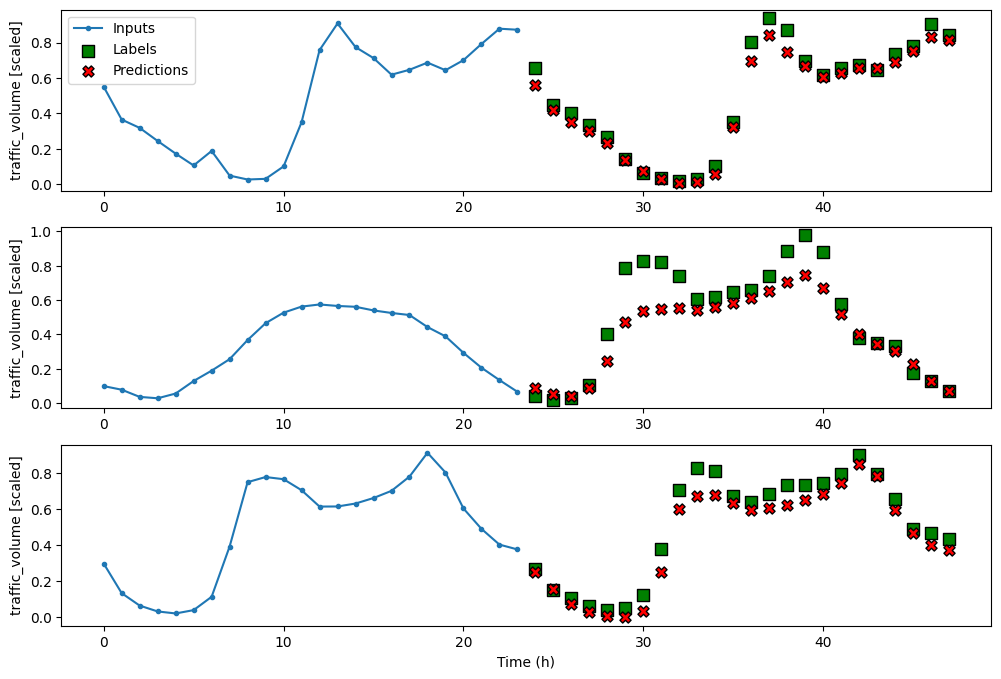

In [52]:
multi_window.plot(ms_lstm_model)

### Compare Multi-Step Models

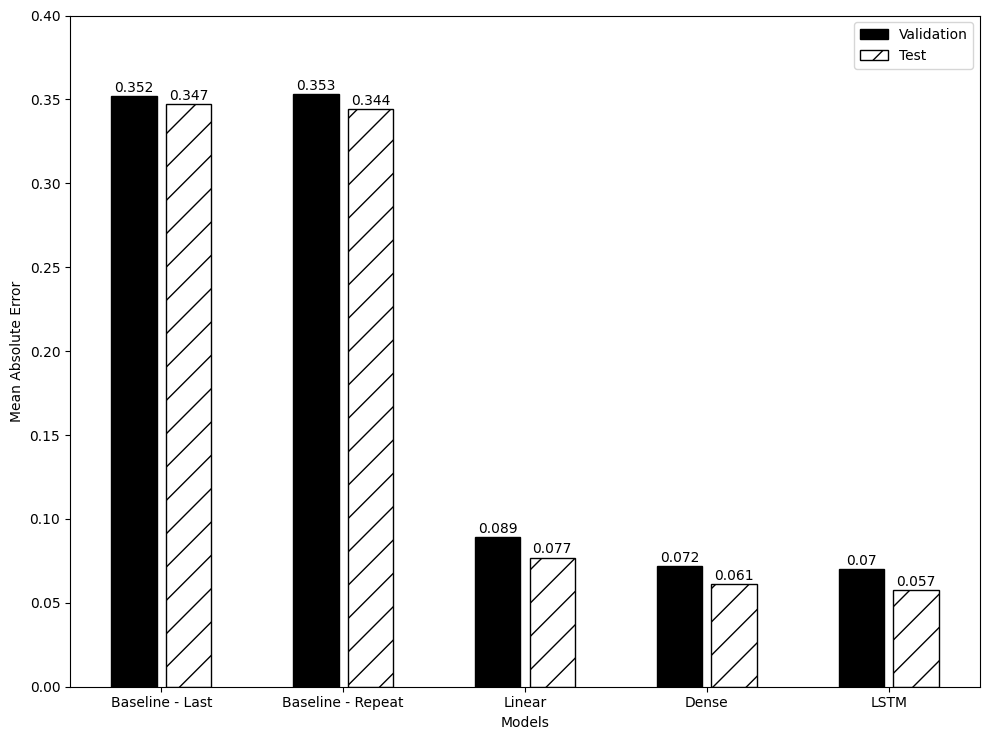

In [53]:
# MAE's of Multi-Step Models from traffic_flow_forecasting_part_1.ipynb
ms_mae_val = [0.352, 0.353, 0.089, 0.072]
ms_mae_test = [0.347, 0.344, 0.077, 0.061]

# Add LSTM model results to the above arrays 
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

# ---------------------------------------------------------------
x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')
  
for index, value in enumerate(ms_mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig(f'{images_dir}/compare_multi_step_models', dpi=300)

## Multi-output Model

In [56]:
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, 
                            label_columns=['temp', 'traffic_volume'])

In [57]:
mo_lstm_model = Sequential([LSTM(32, return_sequences=True), Dense(units = 2)])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 10s 19ms/step - loss: 0.0366 - mean_absolute_error: 0.1220 - val_loss: 0.0116 - val_mean_absolute_error: 0.0690
Epoch 2/50
384/384 [==============================] - 7s 17ms/step - loss: 0.0071 - mean_absolute_error: 0.0546 - val_loss: 0.0051 - val_mean_absolute_error: 0.0452
Epoch 3/50
384/384 [==============================] - 6s 17ms/step - loss: 0.0041 - mean_absolute_error: 0.0406 - val_loss: 0.0033 - val_mean_absolute_error: 0.0359
Epoch 4/50
384/384 [==============================] - 7s 18ms/step - loss: 0.0032 - mean_absolute_error: 0.0355 - val_loss: 0.0026 - val_mean_absolute_error: 0.0326
Epoch 5/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0028 - mean_absolute_error: 0.0330 - val_loss: 0.0023 - val_mean_absolute_error: 0.0303
Epoch 6/50
384/384 [==============================] - 6s 15ms/step - loss: 0.0025 - mean_absolute_error: 0.0311 - val_loss: 0.0021 - val_mean_absolute_error: 0.0286
Epoch 7/5

### Plot

#### Traffic Volume

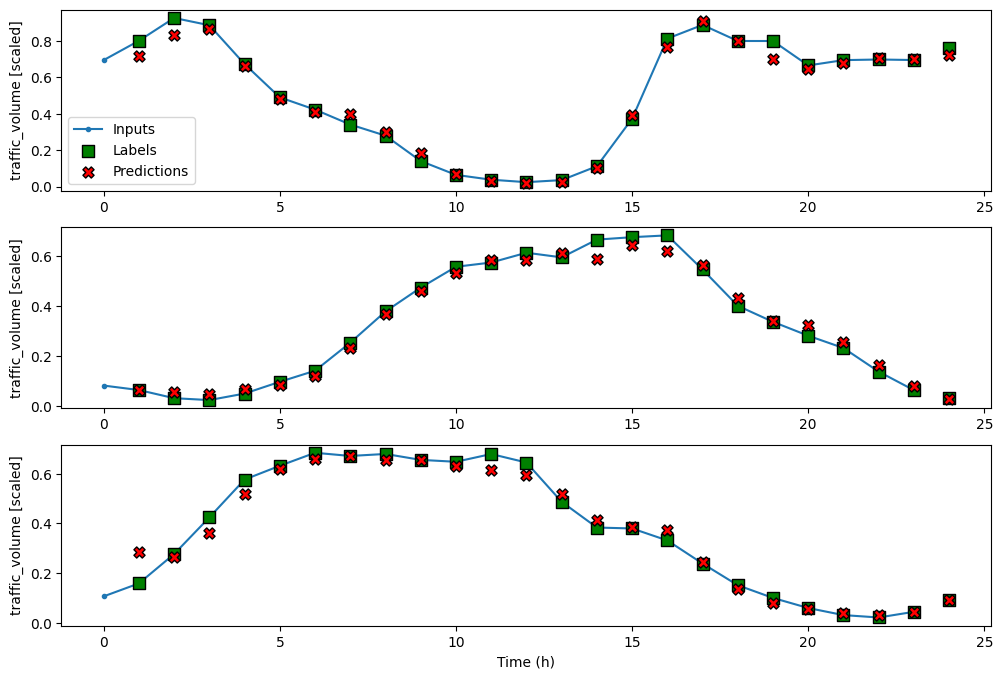

In [58]:
mo_wide_window.plot(mo_lstm_model)

#### Temperature

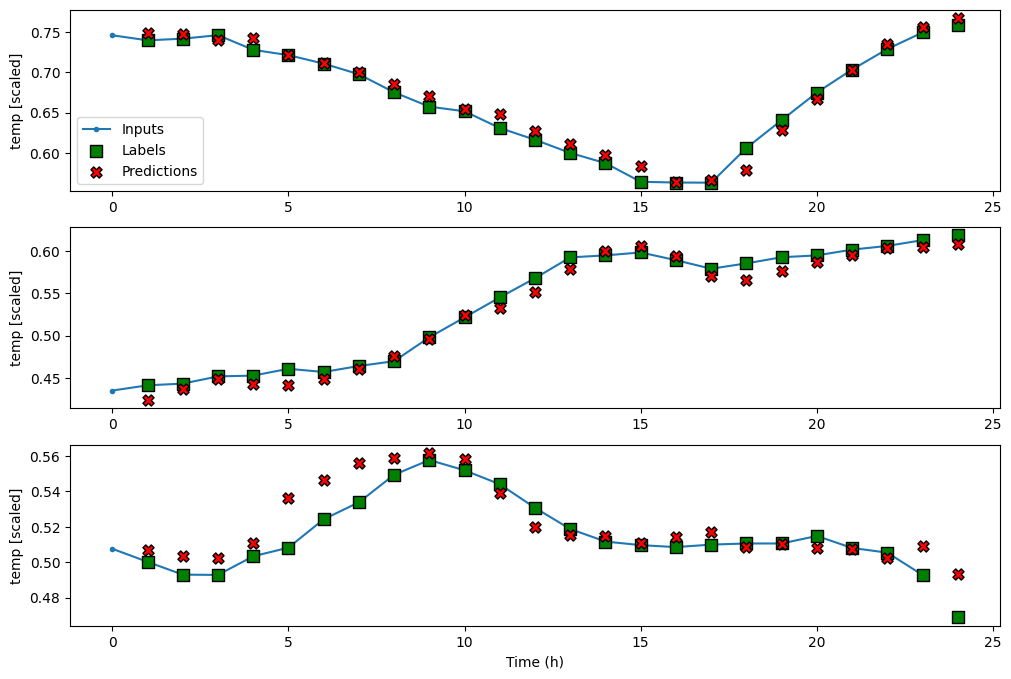

In [59]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

### Compare Multi-Output Models

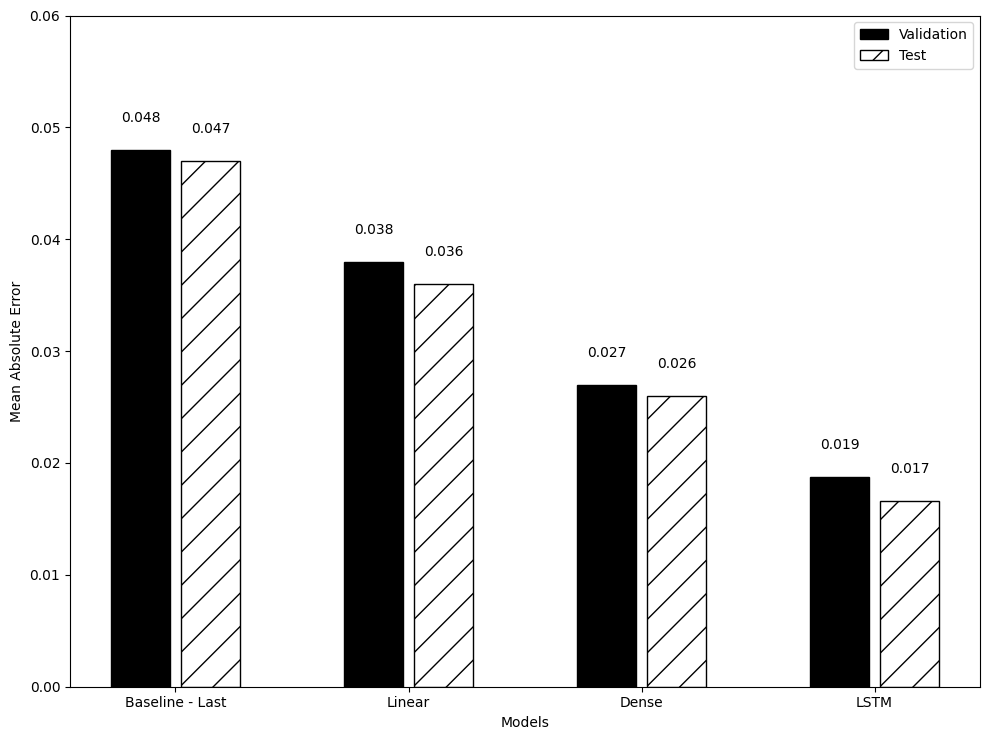

In [61]:
# MAE's of Multi-Step Models from traffic_flow_forecasting_part_1.ipynb
mo_mae_val = [0.048, 0.038, 0.027]
mo_mae_test = [0.047, 0.036, 0.026]

# Add LSTM model results to the above arrays 
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

# ---------------------------------------------------------------
x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')
  
for index, value in enumerate(mo_mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig(f'{images_dir}/compare_multi_output_models', dpi=300)